In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_handler import DataHandler, ScatterDataHandler, BroadcastDataHandler, LatencyDataHandler
import os

## Data loading

In [85]:
dhs = dict()
DATA_PATH = '../output_data'
operations = ('latency', 'scatter', 'broadcast')
        
for operation in operations:
    dhs[operation] = []
    for file in os.listdir(f'{DATA_PATH}/{operation}'):
        if file.endswith('.csv'):
            file_path = f'{DATA_PATH}/{operation}/{file}'
            if operation == 'scatter':
                obj = ScatterDataHandler(file_path)
            elif operation == 'broadcast':
                obj = BroadcastDataHandler(file_path)
            elif operation == 'latency':
                obj = LatencyDataHandler(file_path)
            dhs[operation].append(obj)

## Latency

In order to have a baseline model to compare with, we will use the `osu_latency` benchmark from the `osu-micro-benchmarks` suite. This benchmark measures the latency of a message exchange between two MPI processes. For this test we will use two different partitions: THIN and EPYC. This way we can compare the two architectures.

The tests are:
- **intra socket (EPYC)**:
  - `0:0`
  - ...
  - `0:127`
- **intra socket (THIN)**:
  - `0:0`
  - ...
  - `0:11`
- **intra node (THIN)**:
  - `00:10`
  - `00:13`
  - `00:16`
  - `00:1{10}`
- **intra cluster (THIN)**:
  - `000:100`
  - `000:110`
  - `010:100`

## Intra-Socket

In [86]:
latencies = [ dh for dh in dhs['latency'] if dh.entity == 'socket' ]
print(f'Number of measurements: {len(latencies)}')

Number of measurements: 12


In [87]:
df_latencies = [ dh.data['Avg Latency (us)'] for dh in latencies ]
df_latency = pd.DataFrame(df_latencies).T
df_latency.columns = [f'0-{i}' for i in range(len(df_latencies))]

df_latency.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,0-8,0-9,0-10,0-11
Size,,,,,,,,,,,,
2,12599.98,0.18,0.18,0.20,0.19,0.19,0.19,0.24,0.19,0.18,0.18,0.19
4,12404.97,0.23,0.18,0.19,0.19,0.24,0.19,0.18,0.22,0.18,0.18,0.18
8,12359.95,0.19,0.18,0.20,0.19,0.24,0.19,0.19,0.19,0.19,0.25,0.19
16,12794.97,0.19,0.18,0.20,0.19,0.21,0.19,0.19,0.19,0.19,0.18,0.19
32,12459.98,0.24,0.24,0.24,0.24,0.25,0.24,0.24,0.25,0.23,0.23,0.25


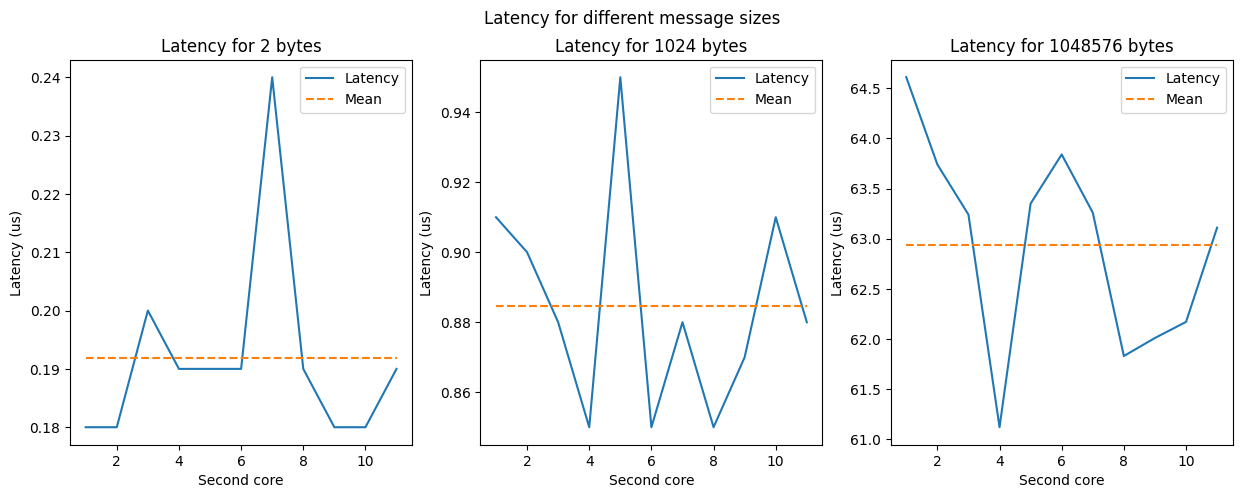

In [88]:
sizes = (2, 1024, 1024*1024)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Latency for different message sizes')

y_new_arr = []

for i, size in enumerate(sizes):
    x = np.arange(len(df_latencies))
    y_arr = np.array([ df_latency[f'0-{i}'][size] for i in range(len(df_latencies)) ])
    y_mean = np.mean(y_arr[1:])
    ax[i].plot(x[1:], y_arr[1:], label='Latency')
    ax[i].plot(x[1:], [y_mean] * len(x[1:]), label='Mean', linestyle='--')
    ax[i].set_title(f'Latency for {size} bytes')
    ax[i].set_xlabel('Second core')
    ax[i].set_ylabel('Latency (us)')
    ax[i].legend()
plt.show()

#### Latency between 0 and 1 all message sizes

In [89]:
from sklearn import linear_model

y = df_latency['0-1'].values
x = df_latency.index.values.reshape(-1, 1)

linreg = linear_model.LinearRegression()
linreg.fit(x, y)
y_pred = linreg.predict(x)

slope, intercept = linreg.coef_[0] * 1e6, linreg.intercept_
print(f'Slope: {slope:.2f} us/byte')
print(f'Intercept: {intercept:.2f} us')

Slope: 60.55 us/byte
Intercept: 1.50 us


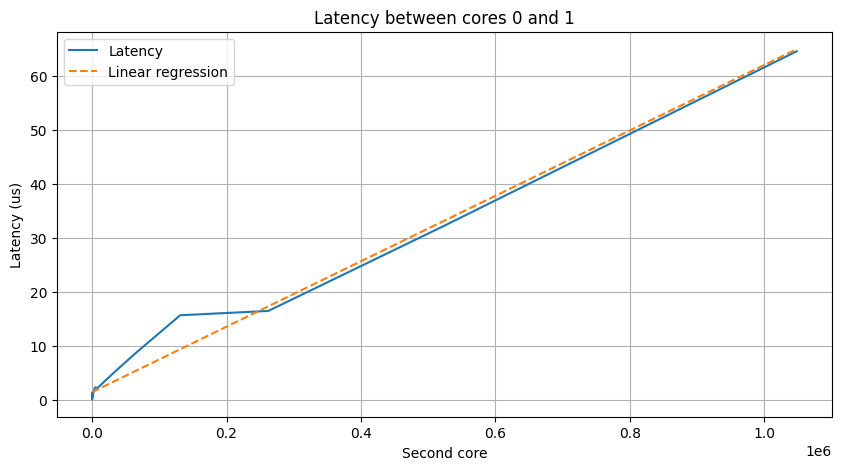

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, y, label='Latency')
ax.plot(x, y_pred, label='Linear regression', linestyle='--')
ax.set_title('Latency between cores 0 and 1')
ax.set_xlabel('Second core')
ax.set_ylabel('Latency (us)')
ax.legend()
ax.grid()
plt.show()

### Intra Node

In [91]:
latencies = [ dh for dh in dhs['latency'] if dh.entity == 'node' ]
print(f'Number of measurements: {len(latencies)}')

Number of measurements: 4


In [92]:
df_latencies = [ dh.data['Avg Latency (us)'] for dh in latencies ]
df_latency = pd.DataFrame(df_latencies).T
df_latency.columns = [f'0-{i}' for i in range(len(df_latencies))]

df_latency.head()

,0-0,0-1,0-2,0-3
Size,,,,
2,0.40,0.41,0.42,0.40
4,0.39,0.40,0.40,0.40
8,0.40,0.41,0.41,0.40
16,0.40,0.43,0.41,0.40
32,0.59,0.59,0.56,0.56


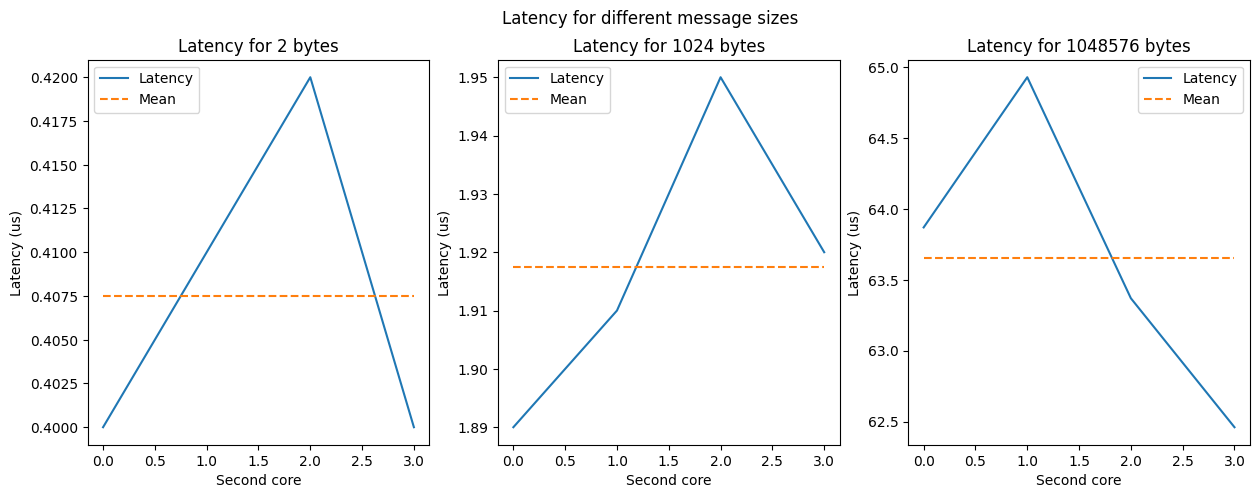

In [93]:
sizes = (2, 1024, 1024*1024)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Latency for different message sizes')

y_new_arr = []

for i, size in enumerate(sizes):
    x = np.arange(len(df_latencies))
    y_arr = np.array([ df_latency[f'0-{i}'][size] for i in range(len(df_latencies)) ])
    y_mean = np.mean(y_arr)
    ax[i].plot(x, y_arr, label='Latency')
    ax[i].plot(x, [y_mean] * len(x), label='Mean', linestyle='--')
    ax[i].set_title(f'Latency for {size} bytes')
    ax[i].set_xlabel('Second core')
    ax[i].set_ylabel('Latency (us)')
    ax[i].legend()
plt.show()

Slope: 59.16 us/byte
Intercept: 4.72 us


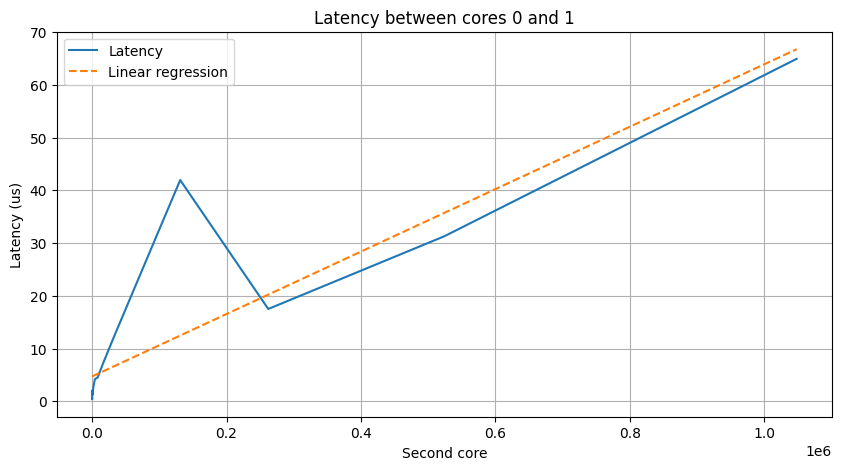

In [94]:
y = df_latency['0-1'].values
x = df_latency.index.values.reshape(-1, 1)

linreg = linear_model.LinearRegression()
linreg.fit(x, y)
y_pred = linreg.predict(x)

slope, intercept = linreg.coef_[0] * 1e6, linreg.intercept_
print(f'Slope: {slope:.2f} us/byte')
print(f'Intercept: {intercept:.2f} us')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, y, label='Latency')
ax.plot(x, y_pred, label='Linear regression', linestyle='--')
ax.set_title('Latency between cores 0 and 1')
ax.set_xlabel('Second core')
ax.set_ylabel('Latency (us)')
ax.legend()
ax.grid()
plt.show()

### Intra Cluster

In [95]:
latencies = [ dh for dh in dhs['latency'] if dh.entity == 'cluster' ]
print(f'Number of measurements: {len(latencies)}')

Number of measurements: 4


In [96]:
df_latencies = [ dh.data['Avg Latency (us)'] for dh in latencies ]
df_latency = pd.DataFrame(df_latencies).T
df_latency.columns = [f'0-{i}' for i in range(len(df_latencies))]

df_latency.head()

,0-0,0-1,0-2,0-3
Size,,,,
2,1.01,1.16,1.17,1.17
4,1.02,1.10,1.12,1.18
8,1.07,1.09,1.11,1.23
16,1.02,1.10,1.14,1.17
32,1.05,1.18,1.19,1.21


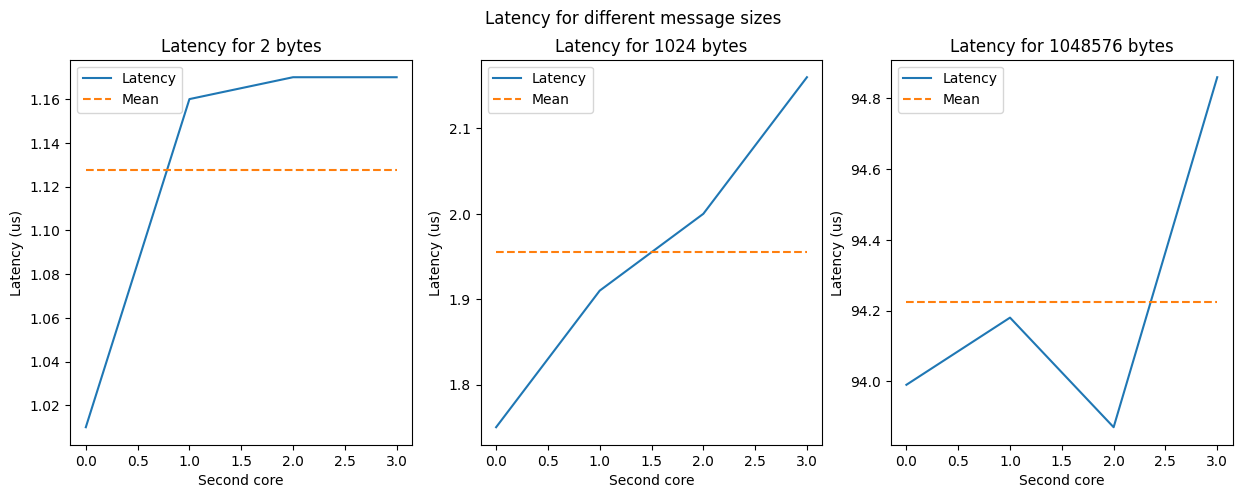

In [97]:
sizes = (2, 1024, 1024*1024)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Latency for different message sizes')

y_new_arr = []

for i, size in enumerate(sizes):
    x = np.arange(len(df_latencies))
    y_arr = np.array([ df_latency[f'0-{i}'][size] for i in range(len(df_latencies)) ])
    y_mean = np.mean(y_arr)
    ax[i].plot(x, y_arr, label='Latency')
    ax[i].plot(x, [y_mean] * len(x), label='Mean', linestyle='--')
    ax[i].set_title(f'Latency for {size} bytes')
    ax[i].set_xlabel('Second core')
    ax[i].set_ylabel('Latency (us)')
    ax[i].legend()
plt.show()

Slope: 88.63 us/byte
Intercept: 3.16 us


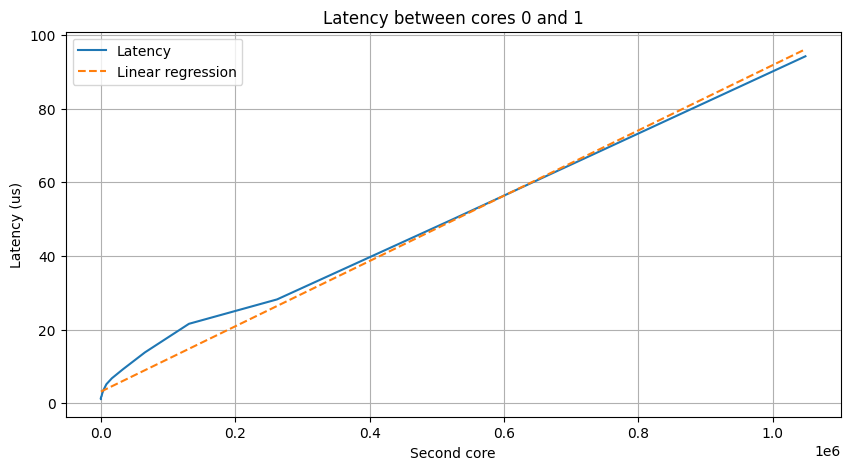

In [98]:
y = df_latency['0-1'].values
x = df_latency.index.values.reshape(-1, 1)

linreg = linear_model.LinearRegression()
linreg.fit(x, y)
y_pred = linreg.predict(x)

slope, intercept = linreg.coef_[0] * 1e6, linreg.intercept_
print(f'Slope: {slope:.2f} us/byte')
print(f'Intercept: {intercept:.2f} us')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, y, label='Latency')
ax.plot(x, y_pred, label='Linear regression', linestyle='--')
ax.set_title('Latency between cores 0 and 1')
ax.set_xlabel('Second core')
ax.set_ylabel('Latency (us)')
ax.legend()
ax.grid()
plt.show()

## Broadcast

We will do three plots one for each implementation of the broadcast algorithm:
1. Basic linear
2. Chain
3. Binary tree

In [99]:
dh_bcast_socket = [ dh for dh in dh_bcast if dh.entity == 'core' ]
dh_bcast_node = [ dh for dh in dh_bcast if dh.entity == 'socket' ]
dh_bcast_cluster = [ dh for dh in dh_bcast if dh.entity == 'node' ]

NameError: name 'dh_bcast' is not defined

In [ ]:
dh_bcast_node

### Intra socket

In [ ]:
dh_bcast_temp = dh_bcast_socket
algorithm = 5
_x = np.array([ dh.n_proc for dh in dh_bcast_temp if dh.algorithm == algorithm ]).flatten()
_y = np.array([ dh.data.index for dh in dh_bcast_temp if dh.algorithm == algorithm ][0]).flatten()
x, y = np.meshgrid(_x, _y)

def fn(n_proc, size):
    # Find the latency value for the given number of processes and message size
    dh = [ dh for dh in dh_bcast_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
    return dh.data.loc[size]['Avg Latency (us)']
fn = np.vectorize(fn)

z = fn(x, y)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

ax.plot_surface(x, y, z, cmap='viridis')
ax.set_xlabel('Number of processes')
ax.set_ylabel('Message size')
ax.set_zlabel('Latency (us)')

# Save to pdf 
filename = f'bcast_socket_alg{algorithm}.pdf'
plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')

In [ ]:
algorithms = [1,2,5]

dh_bcast_temp = dh_bcast_socket
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_bcast_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_bcast_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_bcast_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'bcast_socket_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')
    

dh_bcast_temp = dh_bcast_node
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_bcast_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_bcast_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_bcast_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'bcast_node_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')
    
    
dh_bcast_temp = dh_bcast_cluster
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_bcast_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_bcast_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_bcast_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'bcast_cluster_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')

#### Algorithm comparison

We know fix the message size to 2 bytes and compare the three algorithms.

In [ ]:
def simple_moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    sma = np.convolve(data, weights, 'valid')
    return sma

In [ ]:
# dh_bcast_socket
size = 2
bcast_lat_alg1 = np.array([ dh.time(size) for dh in dh_bcast_socket if dh.algorithm == 1 ]).flatten()
bcast_lat_alg2 = np.array([ dh.time(size) for dh in dh_bcast_socket if dh.algorithm == 2 ]).flatten()
bcast_lat_alg5 = np.array([ dh.time(size) for dh in dh_bcast_socket if dh.algorithm == 5 ]).flatten()

# Simple Moving Average
window_size = 1
bcast_lat_alg1 = simple_moving_average(bcast_lat_alg1, window_size)
bcast_lat_alg2 = simple_moving_average(bcast_lat_alg2, window_size)
bcast_lat_alg5 = simple_moving_average(bcast_lat_alg5, window_size)

x = np.array([ dh.n_proc for dh in dh_bcast_socket if dh.algorithm == 1 ]).flatten()

# Compare with a plot
fig, ax = plt.subplots()
ax.plot(x[window_size-1:], bcast_lat_alg1, label='Linear')
ax.plot(x[window_size-1:], bcast_lat_alg2, label='Binary Tree')
ax.plot(x[window_size-1:], bcast_lat_alg5, label='Binomial Tree')
ax.set_xlabel('Number of processes')
ax.set_ylabel('Latency (us)')
ax.set_title('Broadcast latency intra-socket')
ax.legend()
plt.show()

ValueError: v cannot be empty

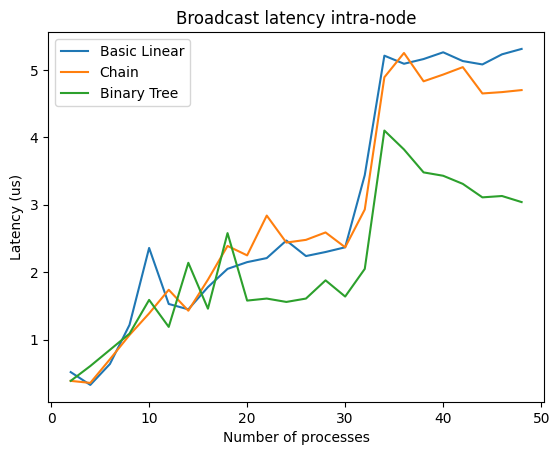

In [ ]:
# dh_bcast_socket
size = 2
bcast_lat_alg1 = np.array([ dh.time(size) for dh in dh_bcast_node if dh.algorithm == 1 ]).flatten()
bcast_lat_alg2 = np.array([ dh.time(size) for dh in dh_bcast_node if dh.algorithm == 2 ]).flatten()
bcast_lat_alg5 = np.array([ dh.time(size) for dh in dh_bcast_node if dh.algorithm == 5 ]).flatten()

# Simple Moving Average
window_size = 1
bcast_lat_alg1 = simple_moving_average(bcast_lat_alg1, window_size)
bcast_lat_alg2 = simple_moving_average(bcast_lat_alg2, window_size)
bcast_lat_alg5 = simple_moving_average(bcast_lat_alg5, window_size)

x = np.array([ dh.n_proc for dh in dh_bcast_node if dh.algorithm == 1 ]).flatten()

# Compare with a plot
fig, ax = plt.subplots()
ax.plot(x[(window_size-1):], bcast_lat_alg1, label='Basic Linear')
ax.plot(x[(window_size-1):], bcast_lat_alg2, label='Chain')
ax.plot(x[(window_size-1):], bcast_lat_alg5, label='Binary Tree')
ax.set_xlabel('Number of processes')
ax.set_ylabel('Latency (us)')
ax.set_title('Broadcast latency intra-node')
ax.legend()
plt.show()

In [ ]:
# dh_bcast_socket
size = 2
bcast_lat_alg1 = np.array([ dh.time(size) for dh in dh_bcast_cluster if dh.algorithm == 1 ]).flatten()
bcast_lat_alg2 = np.array([ dh.time(size) for dh in dh_bcast_cluster if dh.algorithm == 2 ]).flatten()
bcast_lat_alg5 = np.array([ dh.time(size) for dh in dh_bcast_cluster if dh.algorithm == 5 ]).flatten()

# Simple Moving Average
window_size = 1
bcast_lat_alg1 = simple_moving_average(bcast_lat_alg1, window_size)
bcast_lat_alg2 = simple_moving_average(bcast_lat_alg2, window_size)
bcast_lat_alg5 = simple_moving_average(bcast_lat_alg5, window_size)

x = np.array([ dh.n_proc for dh in dh_bcast_cluster if dh.algorithm == 1 ]).flatten()

# Compare with a plot
fig, ax = plt.subplots()
ax.plot(x[(window_size-1):], bcast_lat_alg1, label='Basic Linear')
ax.plot(x[(window_size-1):], bcast_lat_alg2, label='Chain')
ax.plot(x[(window_size-1):], bcast_lat_alg5, label='Binary Tree')
ax.set_xlabel('Number of processes')
ax.set_ylabel('Latency (us)')
ax.set_title('Broadcast latency intra-cluster')
ax.legend()
plt.show()

ValueError: v cannot be empty

## Scatter

Plot in 3D with the following data:
- **x**: number of processes
- **y**: size of the message
- **z**: time taken to broadcast the message

We will do three plots one for each implementation of the broadcast algorithm:
1. Basic linear
2. Binomial

In [ ]:
dh_scat_socket = [ dh for dh in dh_scat if dh.entity == 'core' ]
dh_scat_node = [ dh for dh in dh_scat if dh.entity == 'socket' ]
dh_scat_cluster = [ dh for dh in dh_scat if dh.entity == 'node' ]

In [ ]:
dh_scat_temp = dh_scat_socket
algorithm = 1
_x = np.array([ dh.n_proc for dh in dh_scat_temp if dh.algorithm == algorithm ]).flatten()
_y = np.array([ dh.data.index for dh in dh_scat_temp if dh.algorithm == algorithm ][0]).flatten()
x, y = np.meshgrid(_x, _y)

def fn(n_proc, size):
    # Find the latency value for the given number of processes and message size
    dh = [ dh for dh in dh_scat_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
    return dh.data.loc[size]['Avg Latency (us)']
fn = np.vectorize(fn)

z = fn(x, y)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

ax.plot_surface(x, y, z, cmap='viridis')
ax.set_xlabel('Number of processes')
ax.set_ylabel('Message size')
ax.set_zlabel('Latency (us)')

# Save to pdf 
filename = f'scat_cluster_alg{algorithm}.pdf'
plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')

In [ ]:
dh_scat_temp = dh_scat_socket
algorithms = [1,2]
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_scat_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_scat_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_scat_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'scat_socket_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')
    
dh_scat_temp = dh_scat_node
algorithms = [1,2]
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_scat_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_scat_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_scat_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'scat_node_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')
    
dh_scat_temp = dh_scat_cluster
algorithms = [1,2]
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_scat_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_scat_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_scat_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'scat_cluster_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')